# Data exploration 

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import esda
#----Visulisation----
import contextily 
import seaborn 
import matplotlib.pyplot as plt
from splot import esda as esdaplot
%matplotlib inline

# Preprocessing 
Load the data set and clean it 

In [5]:
df_chicago=pd.read_csv('Crime/Crimes_-_2001_to_Present.csv',index_col='ID')
# clean the data without geocode and time stamp
df_chicago=df_chicago.dropna(subset=['Date','Location'])
df_chicago['Date']=pd.to_datetime(df_chicago['Date'])
# correct the value of crime type
df_chicago['Primary Type'].replace('CRIM SEXUAL ASSAULT','CRIMINAL SEXUAL ASSAULT',inplace=True)
# keep attributes that are relevant to the study only 
df_chicago=df_chicago.drop(columns=['Case Number','FBI Code', 'X Coordinate', 'Y Coordinate','Updated On','Location'])

In [6]:
#get geometry point of data
df_chicago['Location'] = df_chicago.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)
# get geopandas frame
df_chicago=gpd.GeoDataFrame(df_chicago,geometry='Location')

Now combine the data set with the [boundary data of chicago](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

In [7]:
geof='Crime/Boundaries - Community Areas (current).geojson'
chicago_area=gpd.read_file(geof)
# only keep teh information of commuity and geometry
chicago_area=chicago_area[['community','geometry']]
#chicago_area=chicago_area.rename(columns={'area_numbe':'area_num'})

In [8]:
#set crs to the geo dataframe
df_chicago=df_chicago.set_crs(chicago_area.crs)
#spatial join so that crime points are within different communities
df_chicago= df_chicago.sjoin(chicago_area, how='inner',predicate='within')

In [9]:
df_chicago.drop(columns='index_right')

Date                    Block  IUCR  \
ID                                                            
10224853 2015-09-05 16:15:00        041XX W FIFTH AVE  1570   
10232192 2015-09-10 16:00:00       039XX W GLADYS AVE  1750   
10329071 2015-11-29 15:00:00        038XX W WILCOX ST   281   
10240564 2015-09-17 20:00:00  039XX W WASHINGTON BLVD   281   
10242207 2015-09-18 22:35:00       044XX W MADISON ST  1506   
...                      ...                      ...   ...   
12231017 2020-11-24 16:00:00          002XX W 22ND PL   281   
12570868 2020-04-18 15:00:00         019XX S WELLS ST  1562   
10224330 2015-09-04 13:00:00          002XX W 23RD ST   266   
3206905  2004-03-04 13:00:00          002XX W 23RD PL   580   
9993591  2015-03-10 21:30:00    020XX S WENTWORTH AVE  1570   

                        Primary Type                       Description  \
ID                                                                       
10224853                 SEX OFFENSE                  PUBLIC INDECENCY   
10232192  OFFENSE INVOLVING CHILDREN                       CHILD ABUSE   
10329071     CRIMINAL SEXUAL ASSAULT                    NON-AGGRAVATED   
10240564     CRIMINAL SEXUAL ASSAULT                    NON-AGGRAVATED   
10242207                PROSTITUTION             SOLICIT ON PUBLIC WAY   
...                              ...                               ...   
12231017     CRIMINAL SEXUAL ASSAULT                    NON-AGGRAVATED   
12570868                 SEX OFFENSE  AGGRAVATED CRIMINAL SEXUAL ABUSE   
10224330     CRIMINAL SEXUAL ASSAULT                         PREDATORY   
3206905                     STALKING                            SIMPLE   
9993591                  SEX OFFENSE                  PUBLIC INDECENCY   

               Location Description  Arrest  Domestic  Beat  District  Ward  \
ID                                                                            
10224853                   SIDEWALK    True     False  1132      11.0  24.0   
10232192                  RESIDENCE   False      True  1132      11.0  28.0   
10329071                      OTHER   False     False  1122      11.0  28.0   
10240564                  RESIDENCE   False     False  1122      11.0  28.0   
10242207                   SIDEWALK    True     False  1113      11.0  28.0   
...                             ...     ...       ...   ...       ...   ...   
12231017              HOTEL / MOTEL   False     False   914       9.0  25.0   
12570868                  RESIDENCE   False     False   914       9.0  25.0   
10224330  SCHOOL - PRIVATE BUILDING   False     False   914       9.0  25.0   
3206905                      STREET   False     False  2111       9.0  25.0   
9993591                     TAXICAB   False     False   914       9.0  25.0   

          Community Area  Year   Latitude  Longitude  \
ID                                                     
10224853            26.0  2015  41.871884 -87.729404   
10232192            26.0  2015  41.876199 -87.723958   
10329071            26.0  2015  41.878918 -87.721758   
10240564            26.0  2015  41.881853 -87.724613   
10242207            26.0  2015  41.880599 -87.736640   
...                  ...   ...        ...        ...   
12231017            34.0  2020  41.852161 -87.632894   
12570868            34.0  2020  41.855579 -87.632996   
10224330            34.0  2015  41.850959 -87.633322   
3206905             34.0  2004  41.850052 -87.632990   
9993591             34.0  2015  41.855119 -87.631845   

                            Location           community  
ID                                                        
10224853  POINT (-87.72940 41.87188)  WEST GARFIELD PARK  
10232192  POINT (-87.72396 41.87620)  WEST GARFIELD PARK  
10329071  POINT (-87.72176 41.87892)  WEST GARFIELD PARK  
10240564  POINT (-87.72461 41.88185)  WEST GARFIELD PARK  
10242207  POINT (-87.73664 41.88060)  WEST GARFIELD PARK  
...                              ...                 ...  
12231017  PO

In [10]:
# check the type and count of crime data
df_chicago.groupby('Primary Type').size().sort_values()


Primary Type
DOMESTIC VIOLENCE                 1
HUMAN TRAFFICKING                67
STALKING                       3798
SEX OFFENSE                   26328
CRIMINAL SEXUAL ASSAULT       28748
OFFENSE INVOLVING CHILDREN    47860
PROSTITUTION                  68595
dtype: int64

In [11]:
# subset data of interest
# 1. get crime against children 
crime_children= df_chicago[df_chicago['Primary Type']=='OFFENSE INVOLVING CHILDREN']
# 2.combine the sexual violence in one category as sex crime to  analysis
target_type=['SEX OFFENSE ','CRIMINAL SEXUAL ASSAULT']
crime_sexual= df_chicago[df_chicago['Primary Type'].isin(target_type)]
print(f'Size of violence against children: {crime_children.shape[0]}')
print(f'Size of violence against women:{crime_sexual.shape[0]}')

Size of violence against children: 47860
Size of violence against women:28748


# Spatial Pattern Analysis
Code in this section is adapted from 
[construct spatial weight matrix](https://pysal.org/libpysal/generated/libpysal.weights.W.html#libpysal.weights.W)

In [12]:
# Visualise the distribution of different type of violence
# First get the count of crime in different communities
# In this part, the geometry is polygon of communities
count_child=chicago_area.merge(crime_children.groupby('community').size().reset_index(name='crime_count'),on='community')
#child_count.info()
count_sexual=chicago_area.merge(crime_sexual.groupby('community').size().reset_index(name='crime_count'),on='community')


In [13]:
# print out the community with highest count of crime
count_child.sort_values('crime_count')

community                                           geometry  \
76             EDISON PARK  MULTIPOLYGON (((-87.80676 42.00084, -87.80676 ...   
11             FOREST GLEN  MULTIPOLYGON (((-87.76919 42.00489, -87.76919 ...   
74                   OHARE  MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...   
34           ARMOUR SQUARE  MULTIPOLYGON (((-87.62917 41.84556, -87.62947 ...   
42                BURNSIDE  MULTIPOLYGON (((-87.58737 41.72326, -87.58733 ...   
..                     ...                                                ...   
66  GREATER GRAND CROSSING  MULTIPOLYGON (((-87.61562 41.78024, -87.61562 ...   
23           HUMBOLDT PARK  MULTIPOLYGON (((-87.69157 41.88820, -87.69501 ...   
69          AUBURN GRESHAM  MULTIPOLYGON (((-87.63990 41.75615, -87.63990 ...   
38             SOUTH SHORE  MULTIPOLYGON (((-87.54398 41.75515, -87.54400 ...   
25                  AUSTIN  MULTIPOLYGON (((-87.78942 41.91751, -87.78927 ...   

    crime_count  
76           40  
11           57  
74           82  
34           97  
42           98  
..          ...  
66         1552  
23         1556  
69         1895  
38         1991  
25         2753  

[77 rows x 3 columns]

In [14]:
count_sexual.sort_values('crime_count')

community                                           geometry  \
76      EDISON PARK  MULTIPOLYGON (((-87.80676 42.00084, -87.80676 ...   
11      FOREST GLEN  MULTIPOLYGON (((-87.76919 42.00489, -87.76919 ...   
72  MOUNT GREENWOOD  MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ...   
17        MONTCLARE  MULTIPOLYGON (((-87.78942 41.91751, -87.79152 ...   
53        HEGEWISCH  MULTIPOLYGON (((-87.52462 41.69180, -87.52465 ...   
..              ...                                                ...   
36  NEAR NORTH SIDE  MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...   
65        ENGLEWOOD  MULTIPOLYGON (((-87.62826 41.78316, -87.62826 ...   
64   WEST ENGLEWOOD  MULTIPOLYGON (((-87.65487 41.79417, -87.65487 ...   
38      SOUTH SHORE  MULTIPOLYGON (((-87.54398 41.75515, -87.54400 ...   
25           AUSTIN  MULTIPOLYGON (((-87.78942 41.91751, -87.78927 ...   

    crime_count  
76           17  
11           30  
72           43  
17           45  
53           51  
..          ...  
36          943  
65          957  
64          996  
38         1155  
25         1954  

[77 rows x 3 columns]

In [15]:
# get range of data to create a color bar with fiexed interval so the images can compare 
max_count=count_child.crime_count.max()
min_count=count_child.crime_count.min()


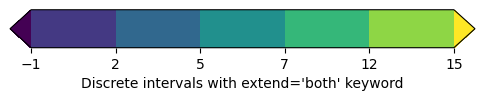

In [16]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.viridis
bounds = [-1, 2, 5, 7, 12, 15]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal',
             label="Discrete intervals with extend='both' keyword")

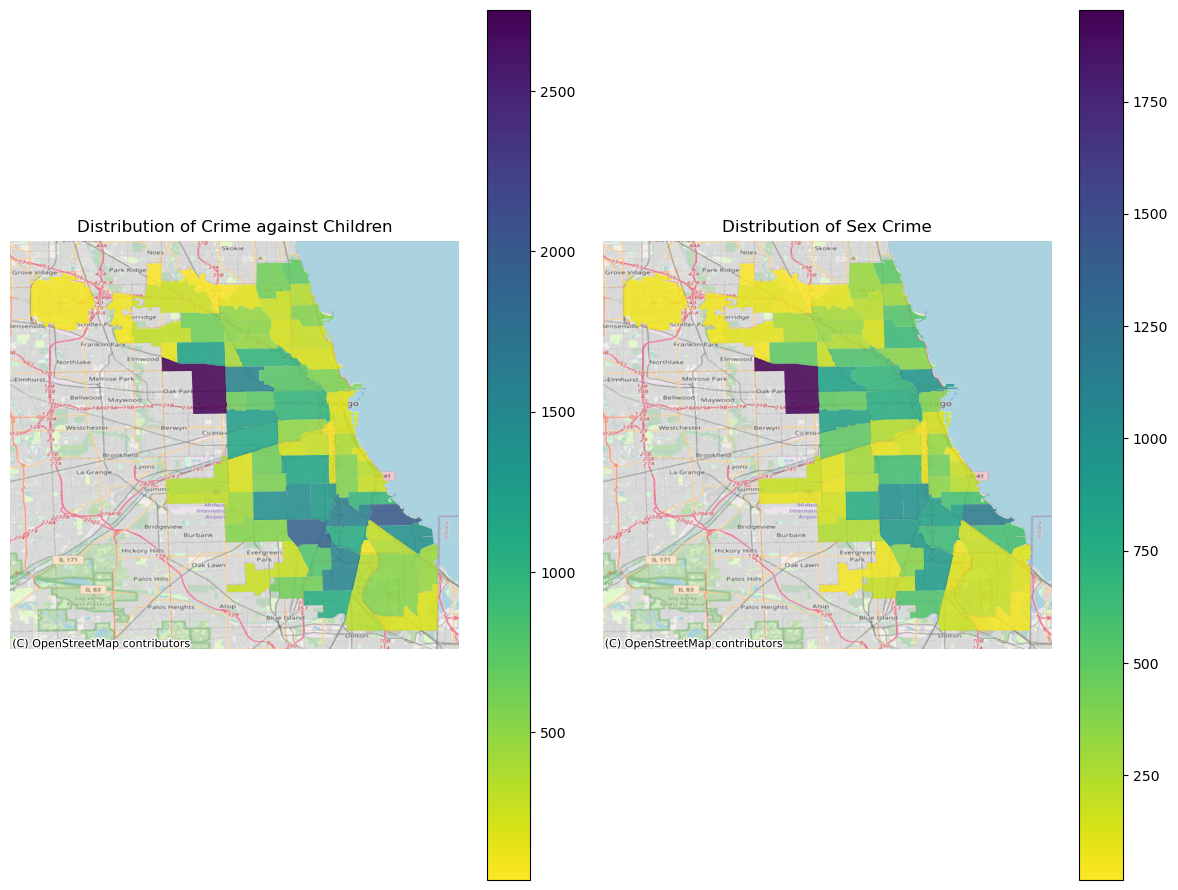

In [17]:
# visualise the distribution of crime count
#set up figure and a single axis
## ---------
#set up cmap with fixed interval to compare


##----------
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(12, 9))
# Build choropleth
#ax1=axs[0]
count_child.plot(
    column='crime_count',
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.85,
    legend=True,
    cmap="viridis_r",
    ax=axs[0],
       
)
# add basemap
contextily.add_basemap(
    axs[0],
    crs=count_child.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)

# Build choropleth of sex crime
count_sexual.plot(
    column='crime_count',
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.85,
    legend=True,
    cmap="viridis_r",
    ax=axs[1],
       
)
# add basemap
contextily.add_basemap(
    axs[1],
    crs=count_sexual.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
# add title
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(["Distribution of Crime against Children",
                  "Distribution of Sex Crime"][i])
fig.tight_layout()

## Spatial Autocorrelation analysis
### Glocal Autocorrelation

In [18]:
#generate spaital weight matrix
# apply the Queen's rule to construct
import libpysal as ps 
from libpysal.weights import Queen
w_c=Queen.from_dataframe(count_child)
# row-standardisation
w_c.transform='R'
# get the spatial lag of crime count
count_child['crime_count_lag']= ps.weights.spatial_lag.lag_spatial(w_c,count_child['crime_count'])
# get the standardised crime count and its spatial lag
count_child['crime_count_std']=count_child['crime_count']-count_child['crime_count'].mean()
count_child['crime_count_lag_std']=count_child['crime_count_lag']-count_child['crime_count_lag'].mean()
# use the row standardised weight to calculate Moran's I
moran= esda.moran.Moran(count_child['crime_count'],w_c)
# retrive the value of Moran's I
print(f"The moran's I for crime against children:{round(moran.I,5)}")
# how likely it is to obtain a pattern like distribution of crime counts in a total randomness situation
# calculated empirical p-value
print(f'empirical p-value:{moran.p_sim}')

The moran's I for crime against children:0.30646
empirical p-value:0.001


In [19]:
# apply the Queen's rule to construct
import libpysal as ps 
from libpysal.weights import Queen
w_s=Queen.from_dataframe(count_sexual)
# row-standardisation
w_s.transform='R'
# get the spatial lag of crime count
count_sexual['crime_count_lag']= ps.weights.spatial_lag.lag_spatial(w_s,count_sexual['crime_count'])
# get the standardised crime count and its spatial lag
count_sexual['crime_count_std']=count_sexual['crime_count']-count_sexual['crime_count'].mean()
count_sexual['crime_count_lag_std']=count_sexual['crime_count_lag']-count_sexual['crime_count_lag'].mean()
# use the row standardised weight to calculate Moran's I
moran= esda.moran.Moran(count_sexual['crime_count'],w_s)
# retrive the value of Moran's I
print(f"The moran's I for crime against women:{round(moran.I,5)}")
# how likely it is to obtain a pattern like distribution of crime counts in a total randomness situation
# calculated empirical p-value
print(f'empirical p-value:{moran.p_sim}')

The moran's I for crime against women:0.29698
empirical p-value:0.002


### Local Spatial Autocorrelation 


Since the global index does not indicate the type of clustering, local indicator of spatial associations shall be caluclated to examine the geographical clusters of crime.

In [20]:
from esda.moran import Moran_Local
lisa_children= esda.moran.Moran_Local(count_child['crime_count'],w_c)
lisa_sex= esda.moran.Moran_Local(count_sexual['crime_count'],w_s)


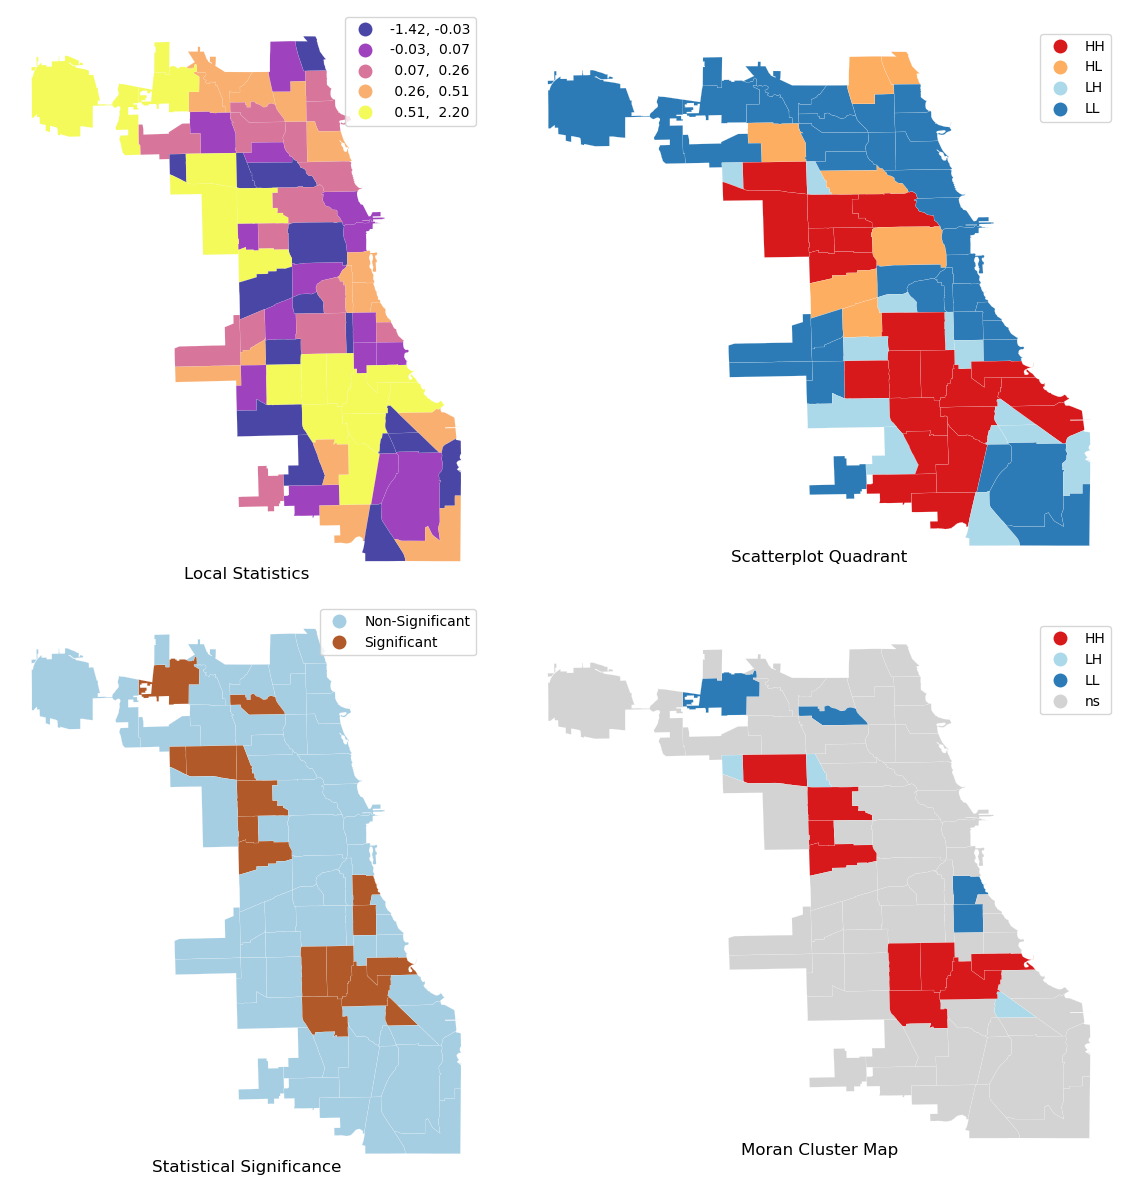

In [21]:
# Visulise LISA to find the statistical clusters
# 1. Choropleth of local statistics of each community
# 2. The quadrant each community is assigned into
# 3. The significance of statistics



# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
count_child.assign(
    Is=lisa_children.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa_children, count_child, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa_children.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=count_child.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
count_child.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_children, count_child, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
#plt.title("LISA of Crime Against Children")
plt.show()

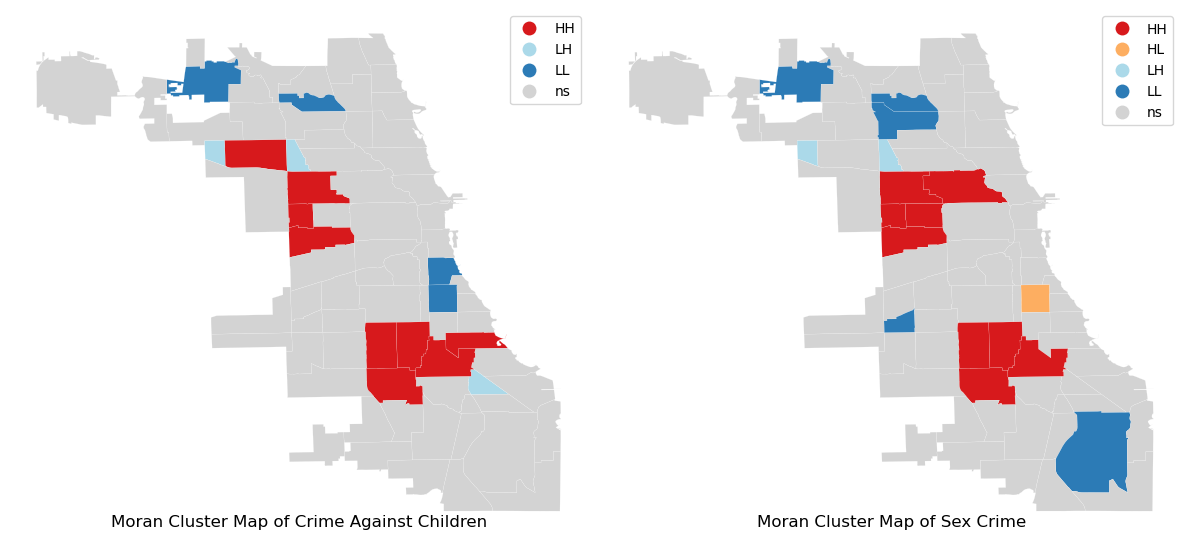

In [22]:
# combine Quadrant categories with significance level to create  cluster map
from splot import esda as esdaplot
# Set up figure and axes
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Grab second axis of local statistics
ax = axs[0]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa_children, count_child, p=0.05, ax=ax)
ax=axs[1]
esdaplot.lisa_cluster(lisa_sex, count_sexual, p=0.05, ax=ax)
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Moran Cluster Map of Crime Against Children",
            "Moran Cluster Map of Sex Crime",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()


## KDE analysis


C:\Users\skyla\AppData\Local\Temp\ipykernel_20172\696437435.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(data=crime_children,
C:\Users\skyla\AppData\Local\Temp\ipykernel_20172\696437435.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(data=crime_sexual,


Text(0.5, 1.0, 'KDE of Sex Crime')

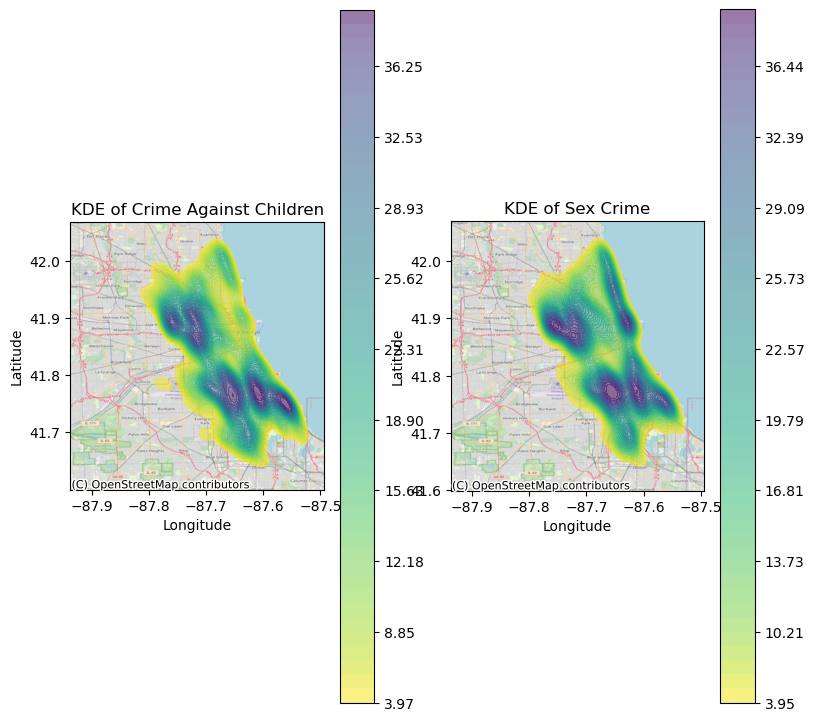

In [23]:
# Set up figure and axis
f, ax = plt.subplots(1,2,figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(data=crime_children,
    x=crime_children["Longitude"],
    y=crime_children["Latitude"],
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
    legend=True,
    cbar=True,ax=ax[0]
)
# Add basemap
contextily.add_basemap(
    ax[0],
    crs=crime_children.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
ax[0].set_title('KDE of Crime Against Children')

## Plot KDE of sex crime
seaborn.kdeplot(data=crime_sexual,
    x=crime_sexual["Longitude"],
    y=crime_sexual["Latitude"],
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
    legend=True,
    cbar=True,ax=ax[1]
)
# Add basemap
contextily.add_basemap(
    ax[1],
    crs=crime_sexual.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
ax[1].set_title("KDE of Sex Crime")

# Temporal analysis


In [24]:
# Explore temporal features
crime_children['day_of_week']=pd.to_datetime(crime_children['Date']).dt.day_of_week
crime_children['hour_of_day']=pd.to_datetime(crime_children['Date']).dt.hour


c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


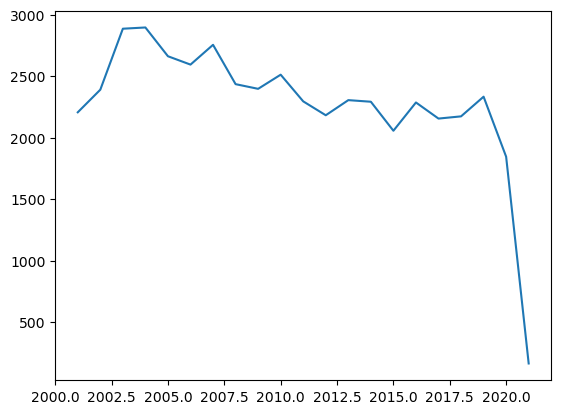

In [25]:
plt.plot(crime_children.groupby(crime_children['Year']).size())

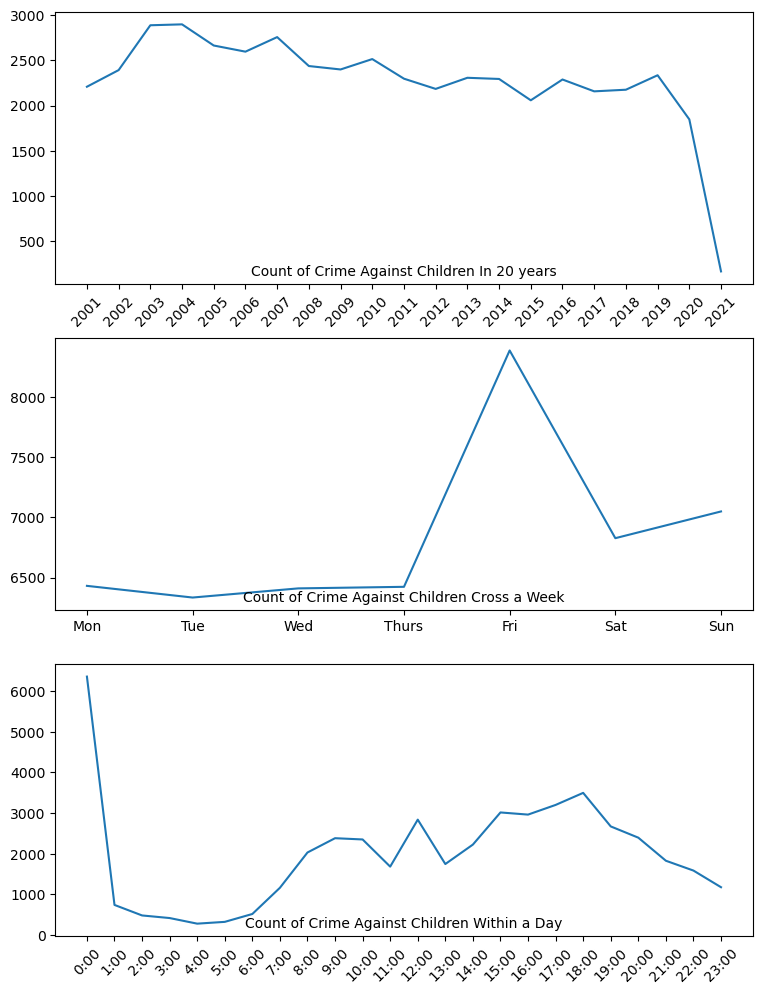

In [26]:

temp_c_weekly=crime_children.groupby(crime_children['day_of_week']).size()# Monday is 0
temp_c_hourly=crime_children.groupby(crime_children['hour_of_day']).size()
temp_c_yearly=crime_children.groupby(crime_children['Year']).size()

fig,axs=plt.subplots(nrows=3,ncols=1,figsize=(9,12))
axs[1].plot(temp_c_weekly)
axs[1].set_xticks(temp_c_weekly.index)
axs[1].set_xticklabels(['Mon','Tue','Wed','Thurs','Fri','Sat','Sun'])

axs[2].plot(temp_c_hourly)
axs[2].set_xticks(temp_c_hourly.index)
axs[2].set_xticklabels([f'{i}:00'for i in temp_c_hourly.index],rotation=45)

axs[0].plot(crime_children.groupby(crime_children['Year']).size())
axs[0].set_xticks(temp_c_yearly.index)
axs[0].set_xticklabels([i for i in temp_c_yearly.index],rotation=45)


for i,ax in enumerate(axs):
        ax.set_title(
        [
            "Count of Crime Against Children In 20 years",
            "Count of Crime Against Children Cross a Week",         
            "Count of Crime Against Children Within a Day"
        ][i],
        y=0,
        fontsize=10,
    )


c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


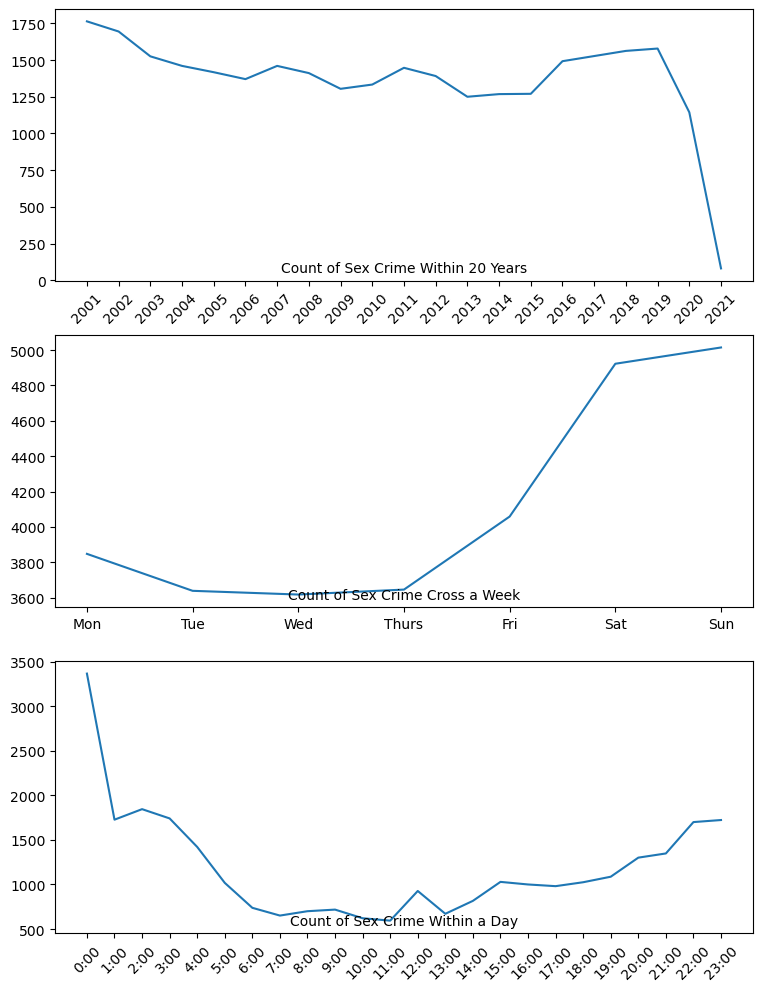

In [27]:
# Explore features
crime_sexual['day_of_week']=pd.to_datetime(crime_sexual['Date']).dt.day_of_week
crime_sexual['hour_of_day']=pd.to_datetime(crime_sexual['Date']).dt.hour
temp_s_weekly=crime_sexual.groupby(crime_sexual['day_of_week']).size()# Monday is 0
temp_s_hourly=crime_sexual.groupby(crime_sexual['hour_of_day']).size()
temp_s_yearly=crime_sexual.groupby(crime_sexual['Year']).size()

fig,axs=plt.subplots(nrows=3,ncols=1,figsize=(9,12))
axs[0].plot(temp_s_yearly)
axs[0].set_xticks(temp_s_yearly.index)
axs[0].set_xticklabels([i for i in temp_s_yearly.index],rotation=45)

axs[1].plot(temp_s_weekly)
axs[1].set_xticks(temp_c_weekly.index)
axs[1].set_xticklabels(['Mon','Tue','Wed','Thurs','Fri','Sat','Sun'])


axs[2].plot(temp_s_hourly)
axs[2].set_xticks(temp_c_hourly.index)
axs[2].set_xticklabels([f'{i}:00'for i in temp_s_hourly.index],rotation=45)


for i,ax in enumerate(axs):
        ax.set_title(
        [   "Count of Sex Crime Within 20 Years",
            "Count of Sex Crime Cross a Week",
            "Count of Sex Crime Within a Day",
            
        ][i],
        y=0,
        fontsize=10,
    )

In [28]:
#check the length of temporal series

#print(f'The earliest time:{crime_children.Date.min()}')
#print(f'The latest time:{crime_children.Date.min()}')

# get data within 20 years
start_date='2001-01-01 00:00:00'
end_date='2020-12-31 23:59:00'
crime_children = crime_children.loc[(crime_children.Date >= start_date) & (crime_children.Date <= end_date)]
crime_sexual = crime_sexual.loc[(crime_sexual.Date >= start_date) & (crime_sexual.Date <= end_date)]


In [29]:
# get the monthly count series of crime data
temp_children=crime_children.groupby(pd.Grouper(key='Date',freq='M')).size()
temp_sex=crime_sexual.groupby(pd.Grouper(key='Date',freq='M')).size()


Text(0.5, 1.0, 'Number of sex crime cases per month')

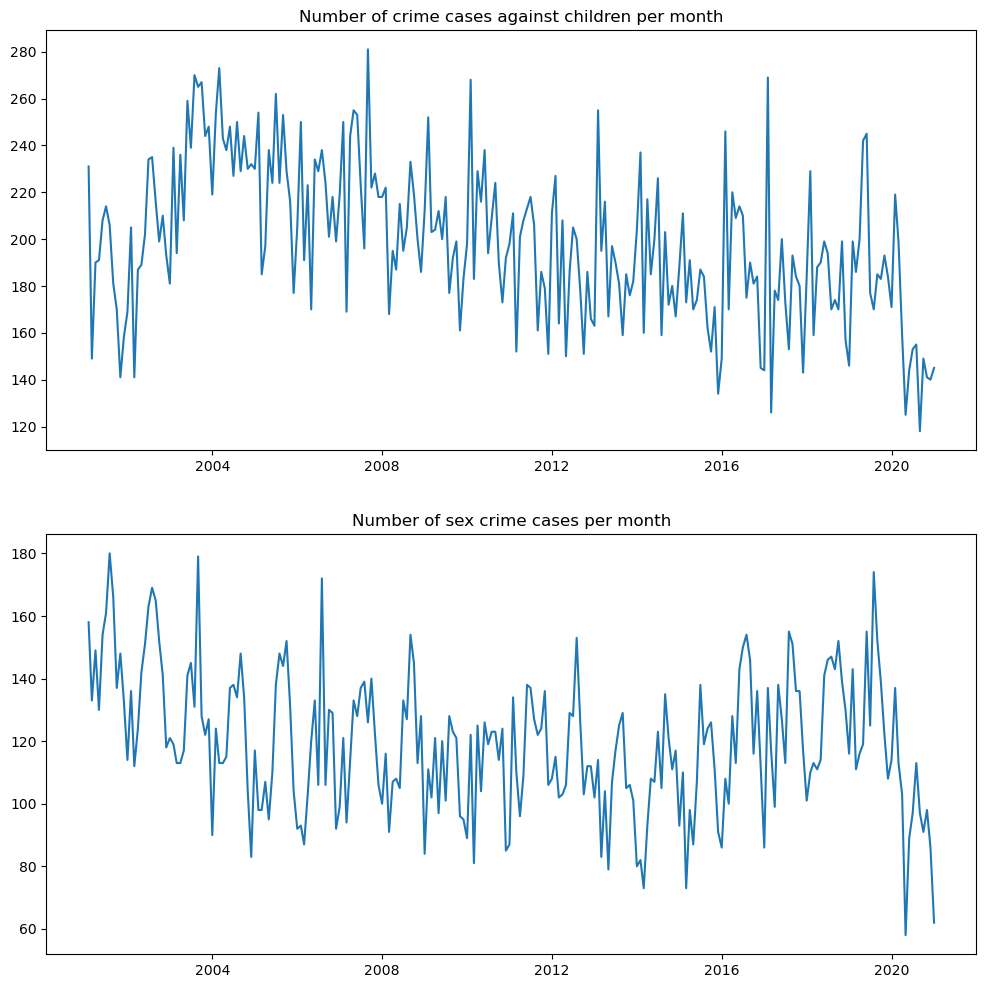

In [30]:
# visualise it
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
ax=axs[0]
ax.plot(temp_children.index,temp_children.values)
ax.set_title('Number of crime cases against children per month')


ax=axs[1]
ax.plot(temp_sex.index,temp_sex.values)
ax.set_title('Number of sex crime cases per month')


Check whether the temporal series is sationary

In [31]:
# conduct Augmented Dickey-Fuller Test
# If the ADF statistics has low p-value and close confidence interval, the time-series will be considered as stationary
from statsmodels.tsa.stattools import adfuller
res=adfuller(temp_children.values)
print(f'Temporal series of crime involves children')
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')

Temporal series of crime involves children
ADF Statistics:-1.1104051087665838
p-value:0.7109046806422059
Critical values
	1%: -3.4594900381360034
	5%: -2.8743581895178485
	10%: -2.573601605503697


In [32]:
res=adfuller(temp_sex.values)
print(f'Temporal series of sex crime')
print(f'ADF Statistics:{res[0]}')
print(f'p-value:{res[1]}')
print(f'Critical values')
for k,v in res[4].items():
    print(f'\t{k}: {v}')

Temporal series of sex crime
ADF Statistics:-1.7325555665701033
p-value:0.4144217110861933
Critical values
	1%: -3.4597521044060353
	5%: -2.874472927517147
	10%: -2.5736628197530864


Both temporal series is not stationary, check acf and pacf.

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


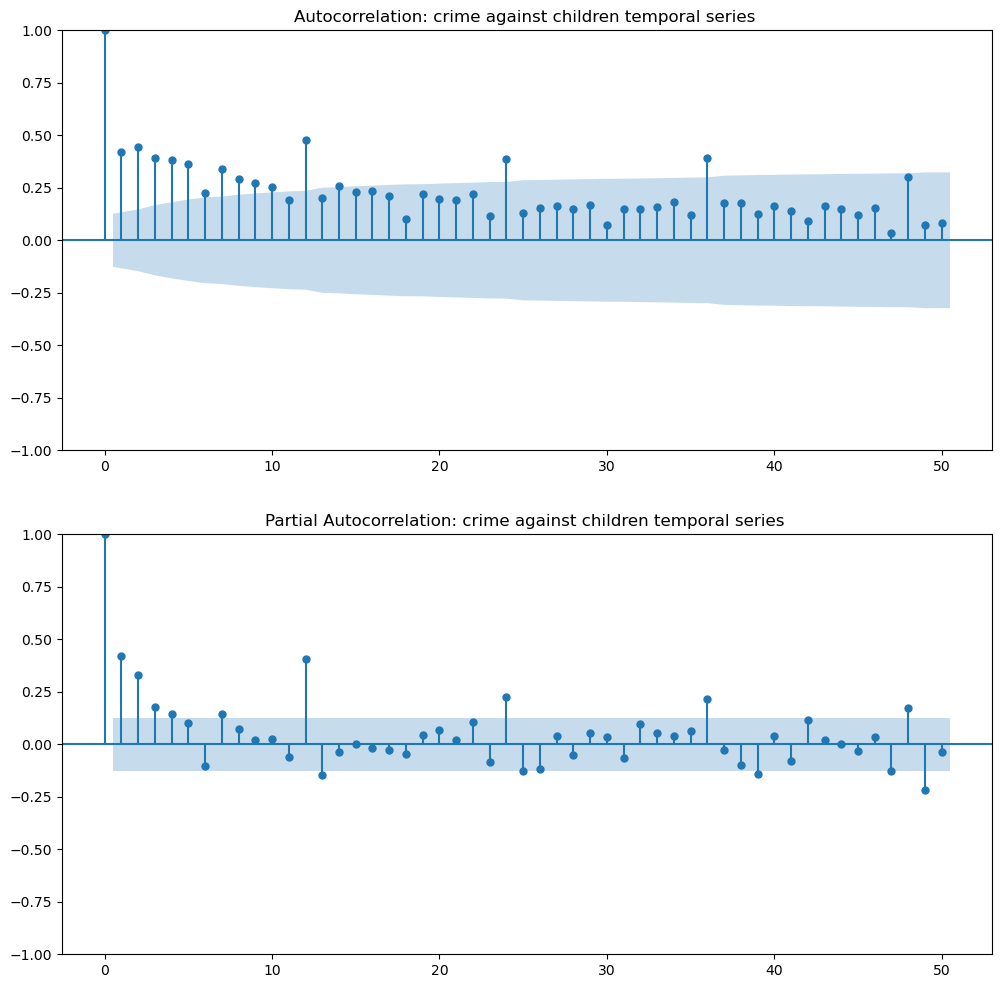

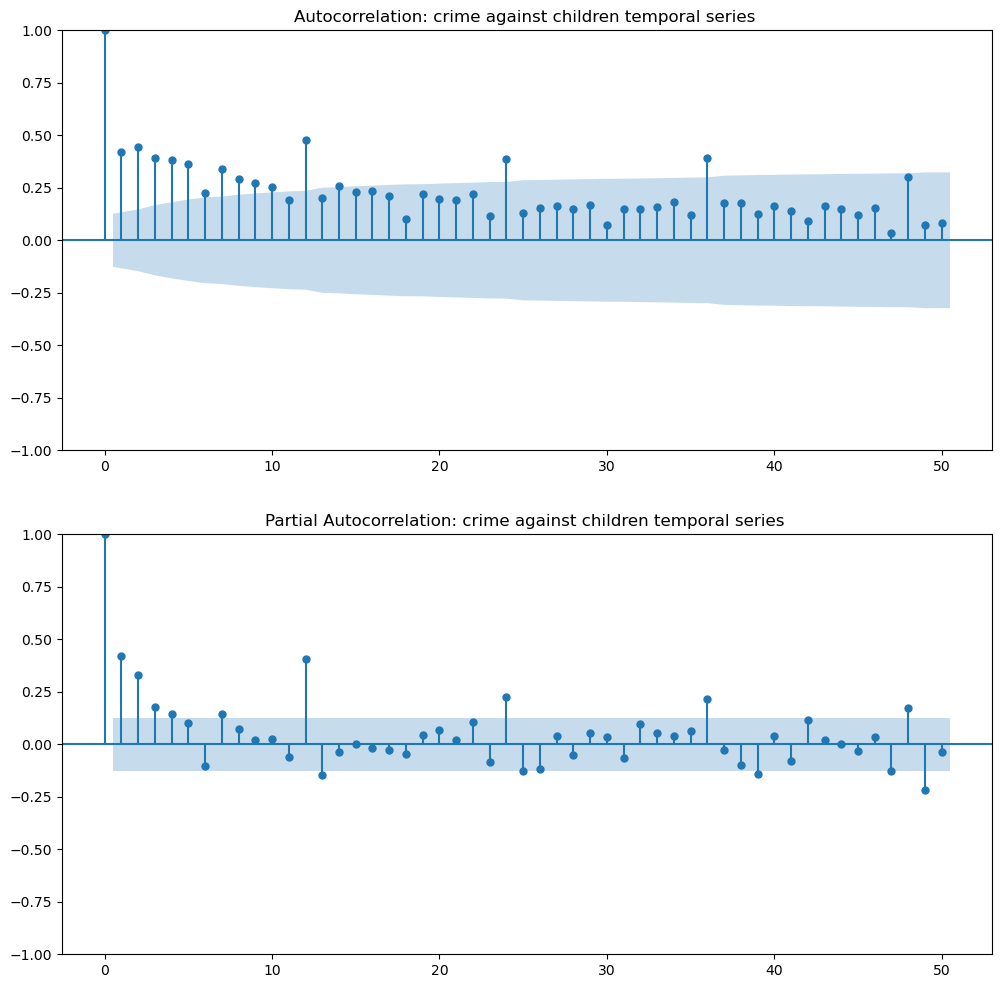

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))

plot_acf(temp_children.values,title='Autocorrelation: crime against children temporal series ',lags=50,ax=axs[0])
plot_pacf(temp_children.values,title='Partial Autocorrelation: crime against children temporal series ',lags=50,ax=axs[1])

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


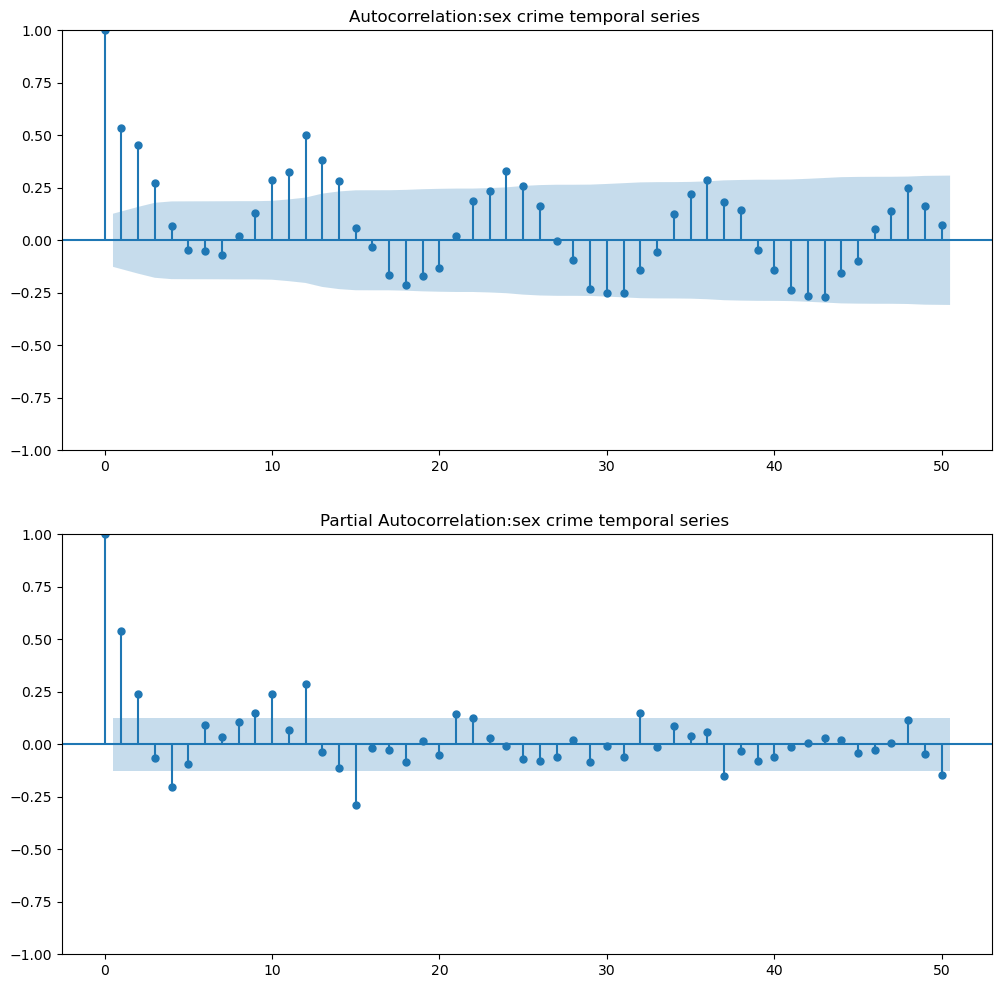

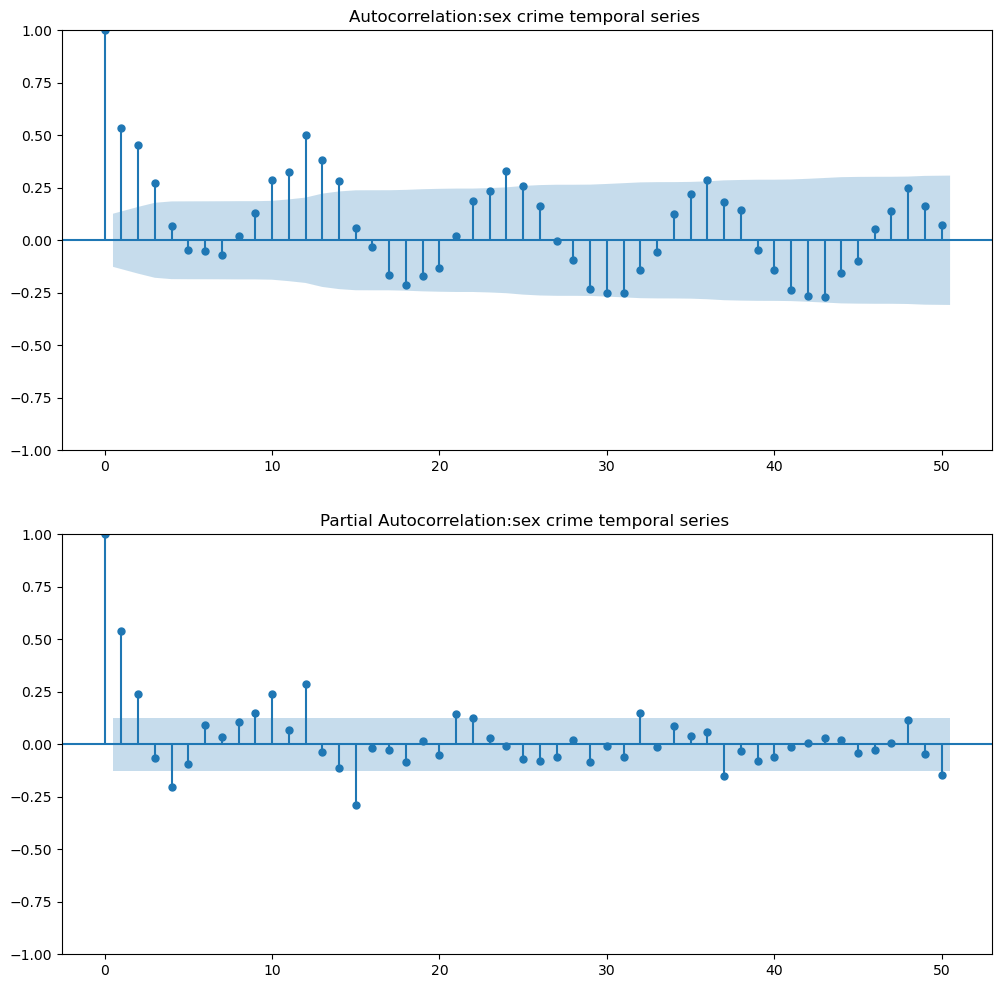

In [34]:
fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))

plot_acf(temp_sex.values,title='Autocorrelation:sex crime temporal series ',lags=50,ax=axs[0])
plot_pacf(temp_sex.values,title='Partial Autocorrelation:sex crime temporal series ',lags=50,ax=axs[1])

The ACF and PACF all indicate strong seasonality of temporal series.

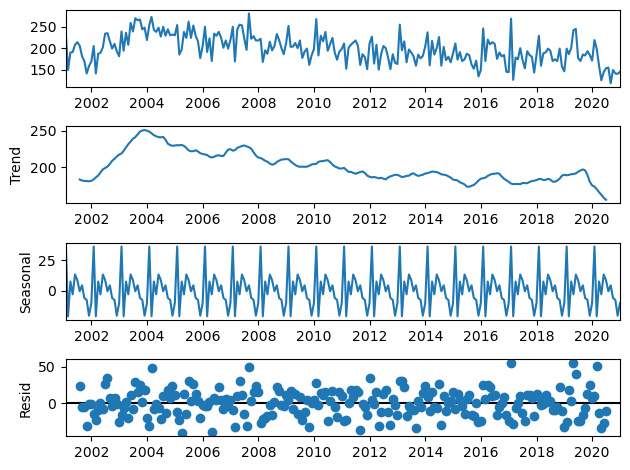

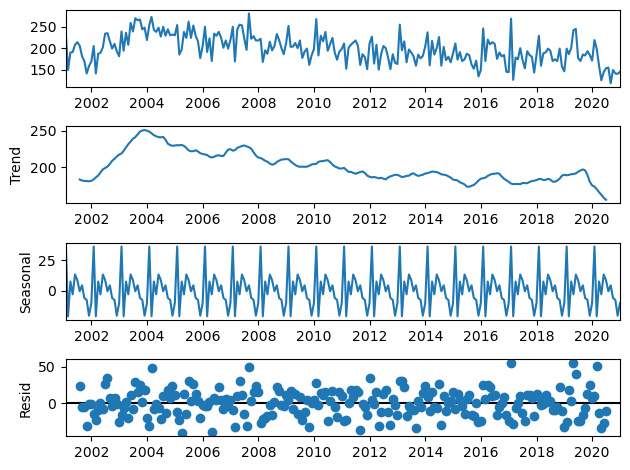

In [35]:
# check whether seasonal pattern exists
from statsmodels.tsa.seasonal import seasonal_decompose
child_temp_decomp=seasonal_decompose(temp_children)
child_temp_decomp.plot()

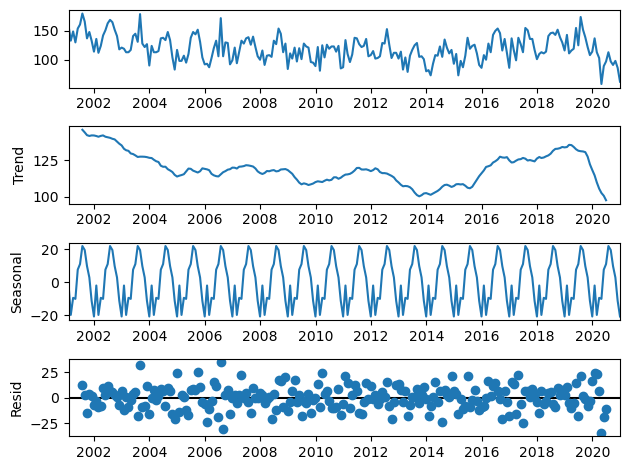

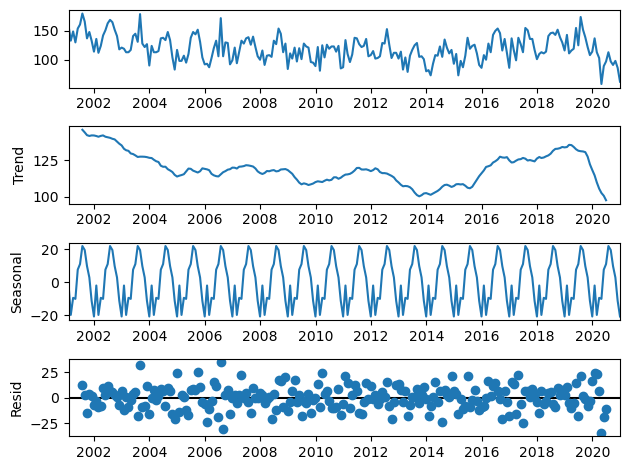

In [36]:
# check seasonality of sex crime
sex_temp_decomp=seasonal_decompose(temp_sex)
sex_temp_decomp.plot()

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


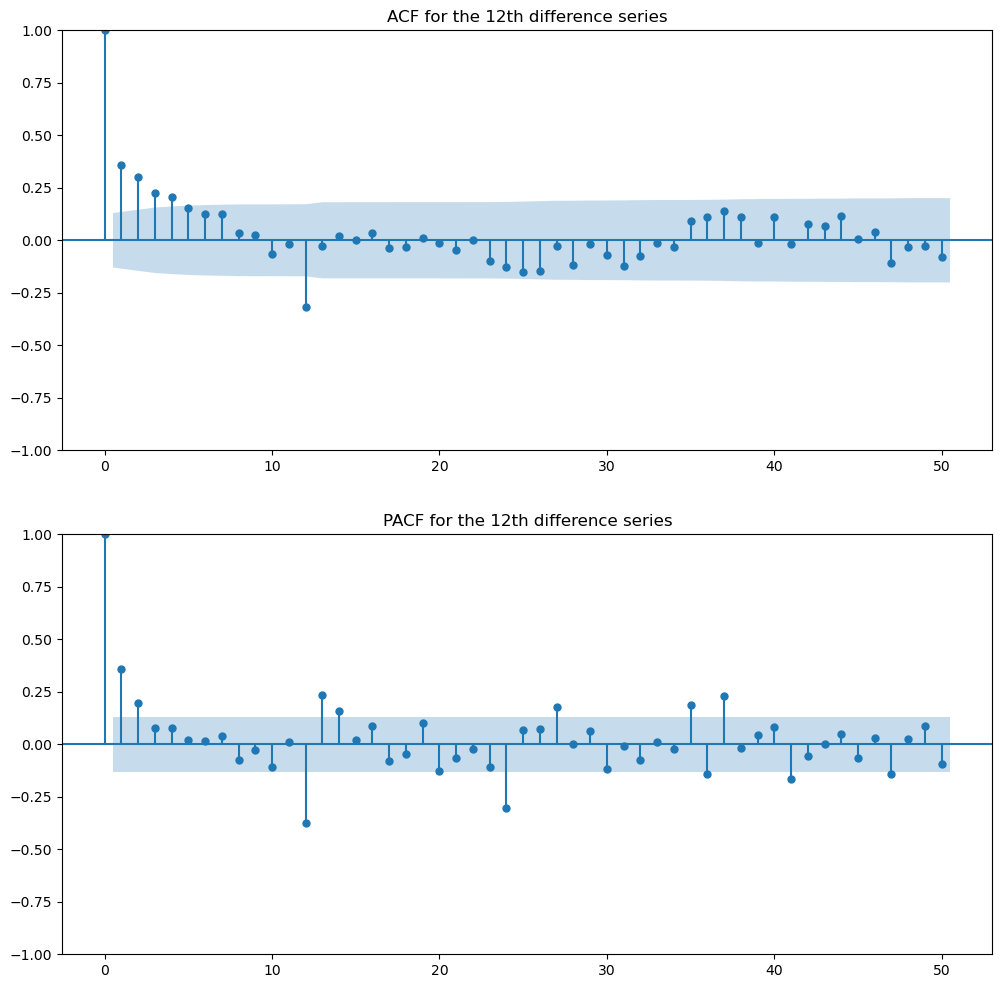

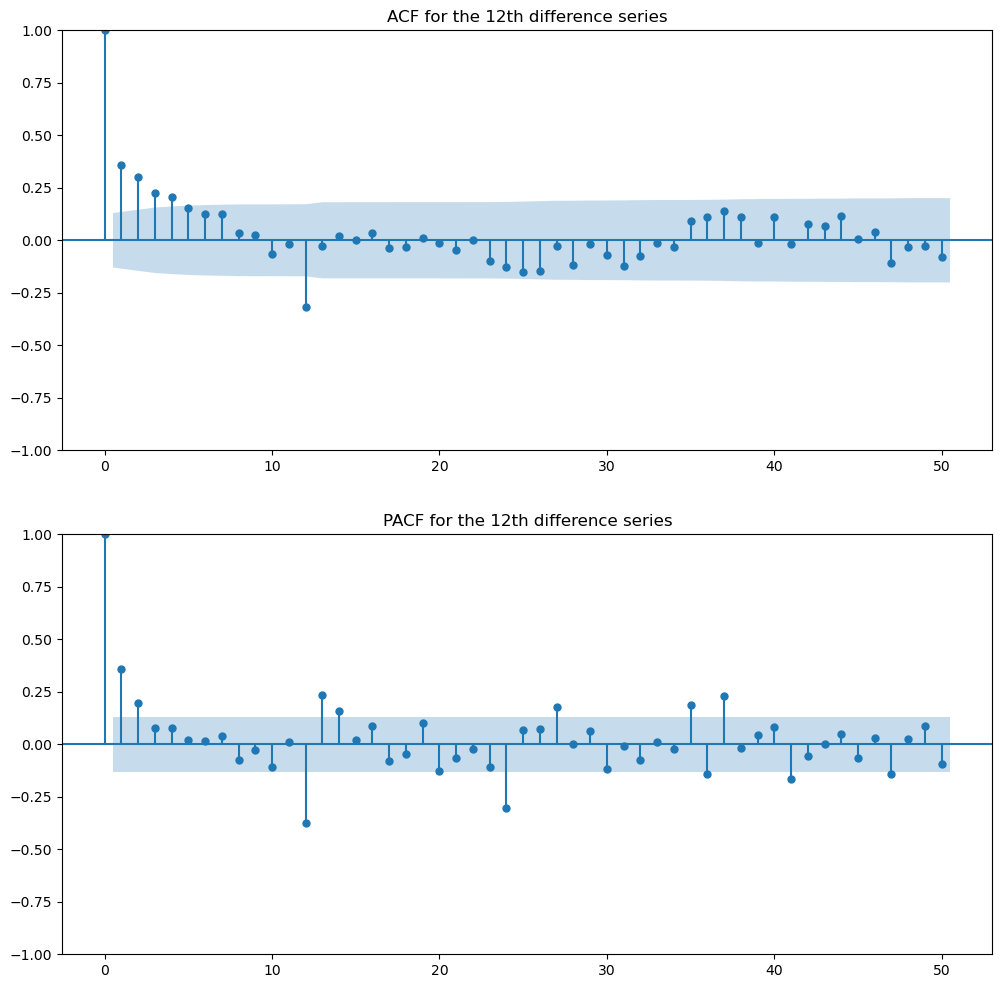

In [37]:
# Try to remove seasonality of crime involving children 
crime_temp_diff12=temp_children.diff(periods=12)[12:]

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
plot_acf(crime_temp_diff12,title='ACF for the 12th difference series',lags=50,ax=axs[0])
plot_pacf(crime_temp_diff12,title='PACF for the 12th difference series',lags=50,ax=axs[1])

c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


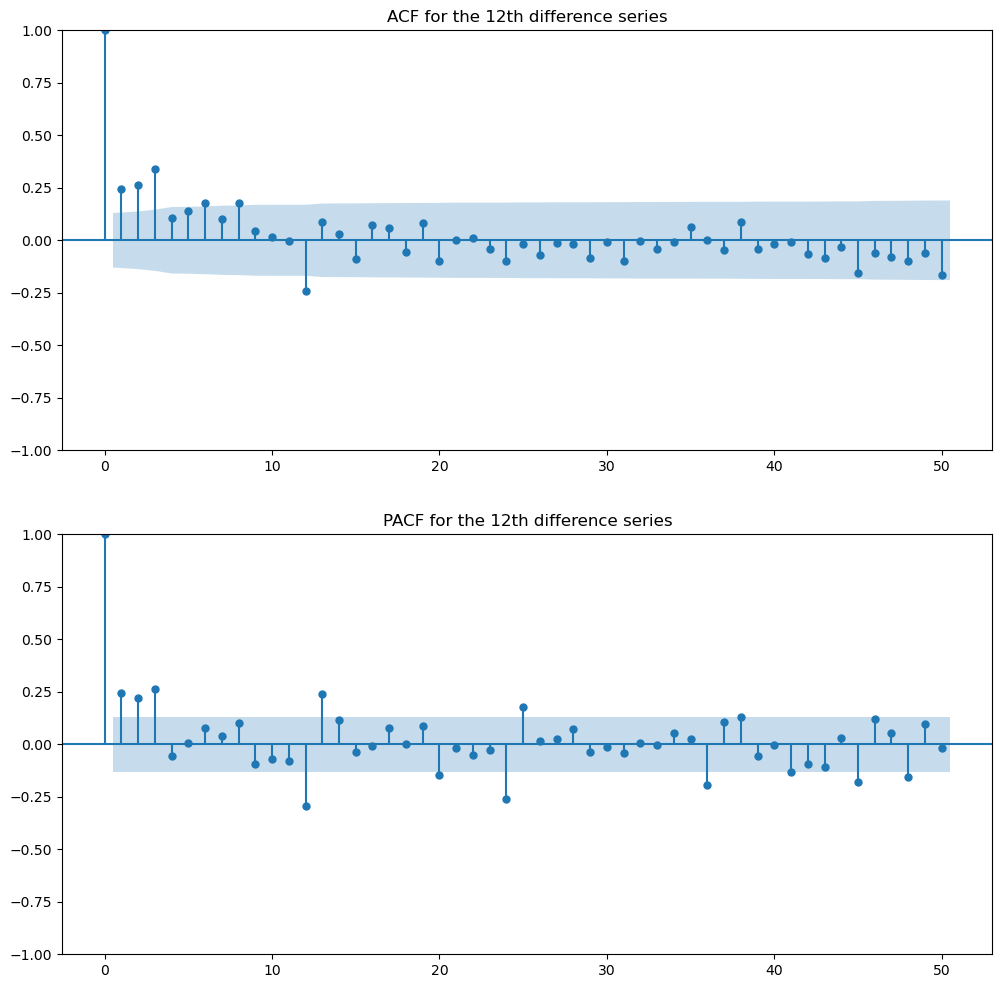

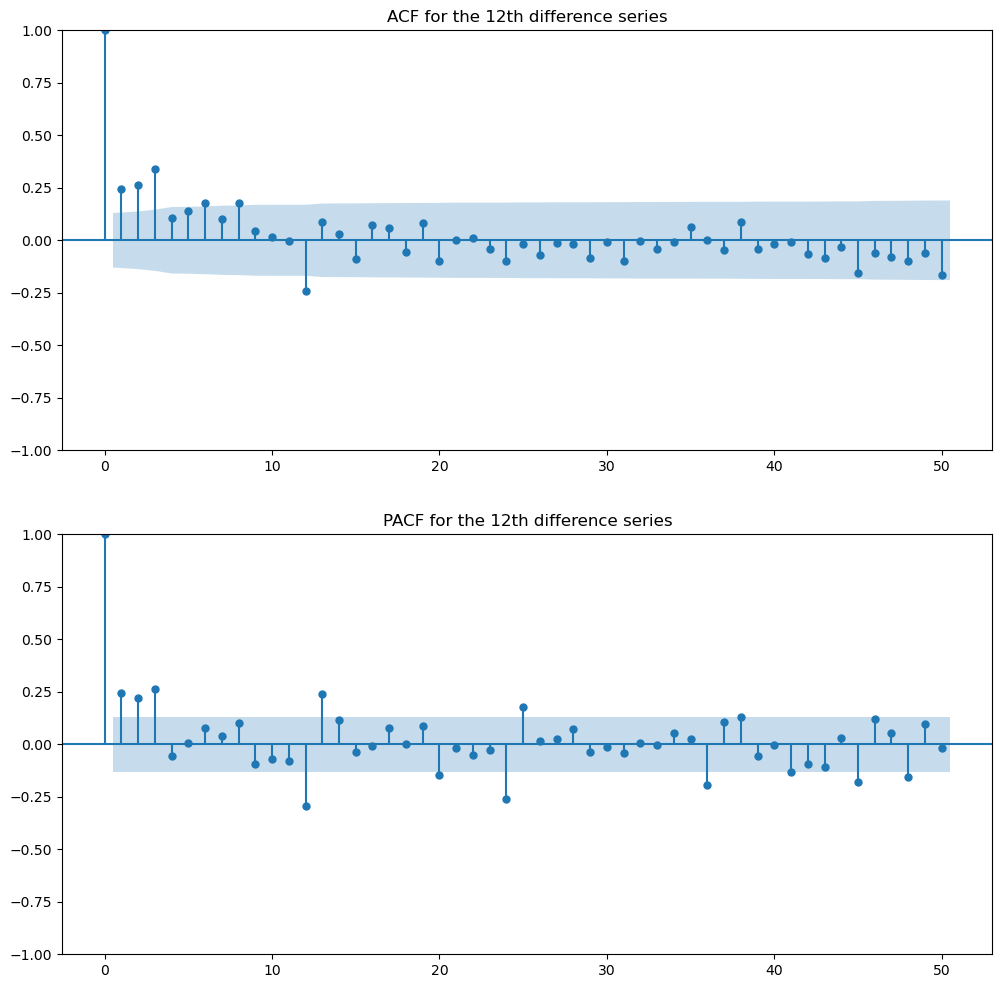

In [38]:
# Try to remove seasonality of sex crime 
crime_temp_diff12=temp_sex.diff(periods=12)[12:]

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
plot_acf(crime_temp_diff12,title='ACF for the 12th difference series',lags=50,ax=axs[0])
plot_pacf(crime_temp_diff12,title='PACF for the 12th difference series',lags=50,ax=axs[1])

## Steps of ARIMA
* model parameter
$ ARIMA (p,d,q)* (P,D,Q)S $

PACF-> AR->p,P

ACF-> MA -> q,Q

p = non-seasonal AR order,
d = non-seasonal differencing,
q = non-seasonal MA order,
P = seasonal AR order,
D = seasonal differencing,
Q = seasonal MA order,

S = time span of repeating seasonal pattern.

In [39]:
# get model
# the following code is adapted from https://pypi.org/project/pmdarima/
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
temp_children_train,temp_children_test=train_test_split(temp_children, train_size=0.8)


model_children = auto_arima(temp_children_train, start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # no need to know if an order does not work
                          suppress_warnings = True,  # no convergence warnings
                          stepwise = True)           # set to stepwise



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1635.831, Time=0.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1741.291, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1690.440, Time=0.28 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1675.842, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1739.330, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1715.520, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1637.821, Time=0.58 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1637.820, Time=0.97 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1674.469, Time=0.45 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=1637.823, Time=0.63 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=1637.824, Time=0.69 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1705.660, Time=0.19 sec
 ARIMA(0,0,2)(0,1,1)[12] inte

In [40]:
# get model for the sex crime
temp_sex_train,temp_sex_test=train_test_split(temp_sex, train_size=0.8)


model_sex = auto_arima(temp_sex_train, start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # no need to know if an order does not work
                          suppress_warnings = True,  # no convergence warnings
                          stepwise = True)           # set to stepwise



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1639.978, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1558.115, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1577.927, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1539.733, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.94 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1599.466, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1508.964, Time=0.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1529.250, Time=0.18 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.18 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1509.113, Time=0.38 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1496.9

In [41]:
# To print the summary
model_sex.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  192
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -742.964
Date:                             Wed, 22 Mar 2023   AIC                           1493.929
Time:                                     12:26:48   BIC                           1506.678
Sample:                                 01-31-2001   HQIC                          1499.099
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8590      0.038    -22.393      0.000      -0.934      -0.784
ar.S.L12      -0.4956      0.080     -6.182      0.000      -0.653      -0.338
ar.S.L24      -0.3579      0.075     -4.776      0.000      -0.505      -0.211
sigma2       227.4751     26.076      8.723      0.000     176.367     278.583
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):                 0.18
Prob(Q):                              0.34   Prob(JB):                         0.91
Heteroskedasticity (H):               0.75   Skew:                             0.01
Prob(H) (two-sided):                  0.26   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

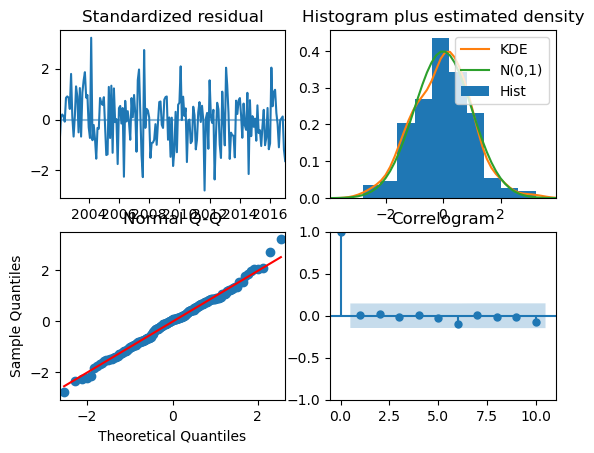

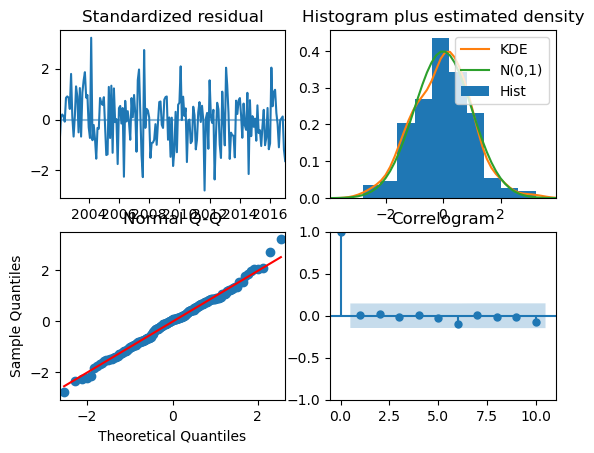

In [42]:
# Check the model by plotting diagnostic 
model_children.plot_diagnostics()

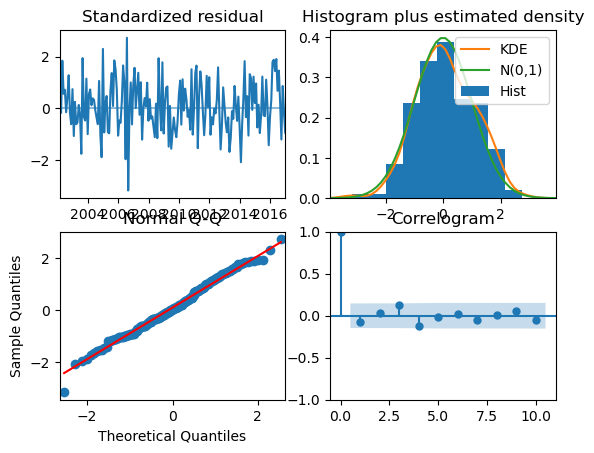

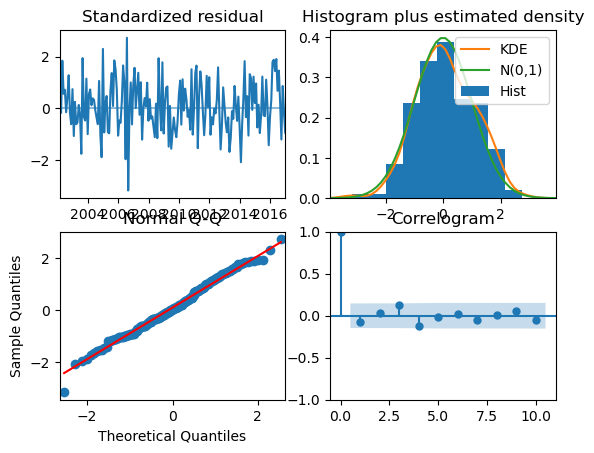

In [43]:
# Check the model by plotting diagnostic 
model_sex.plot_diagnostics()

In [44]:
# Use model to make forcast
pred_c=model_children.predict(temp_children_test.shape[0])
pred_s=model_sex.predict(temp_sex_test.shape[0])

In [45]:
# evaluate model
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
print(f'SARIMAX for Crime against Children RMSE:{rmse(temp_children_test, pred_c)}')
print(f'SARIMAX for Sex Crime RMSE:{rmse(temp_sex_test, pred_s)}')

# Calculate mean squared error
print(f'SARIMAX for Crime against Children MSE:{mean_squared_error(temp_children_test, pred_c)}')
print(f'SARIMAX for Crime against Children MSE:{mean_squared_error(temp_sex_test, pred_s)}')


SARIMAX for Crime against Children RMSE:28.420230745601046
SARIMAX for Sex Crime RMSE:33.00470358441279
SARIMAX for Crime against Children MSE:807.709515633207
SARIMAX for Crime against Children MSE:1089.3104586949505


Text(0.5, 1.0, 'SARIMAX Prediction of Crime Against Children')

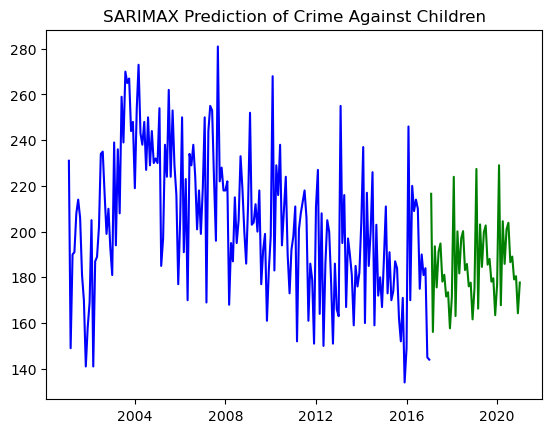

In [46]:
# Visualise the forcasts
x=temp_children.index


plt.plot(x[:temp_children_train.shape[0]], temp_children_train, c='blue')

#plt.plot(x[:temp_children_train.shape[0]], temp_children_test, c='blue')
plt.plot(x[temp_children_train.shape[0]:], pred_c, c='green')
plt.title("SARIMAX Prediction of Crime Against Children")



Text(0.5, 1.0, 'SARIMAX Prediction of Sex Crime')

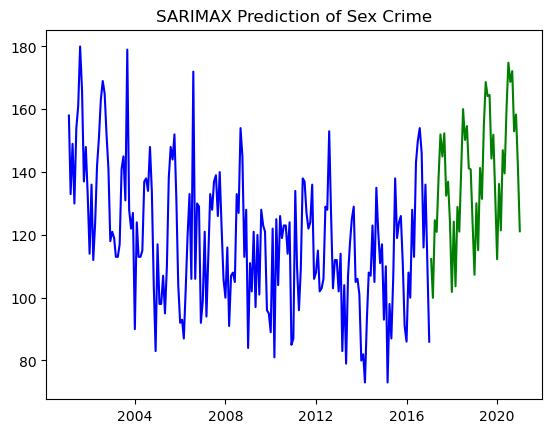

In [47]:
# Visualise the forcasts
x=temp_sex.index


plt.plot(x[:temp_sex_train.shape[0]], temp_sex_train, c='blue')

#plt.plot(x[:temp_children_train.shape[0]], temp_children_test, c='blue')
plt.plot(x[temp_sex_train.shape[0]:], pred_s, c='green')
plt.title("SARIMAX Prediction of Sex Crime")



# Clustering
## DBSCAN


In [48]:
# get the coordinates of crime point
coords_c=np.array(crime_children[['Longitude','Latitude']],dtype='float64')
coords_s=np.array(crime_sexual[['Longitude','Latitude']],dtype='float64')


In [49]:
# define the number of kilometers in one radian
# the algorithm ball_tree requires radian data
kms_per_radian = 6371.0088
epsilon=0.1/kms_per_radian # the range of cluster is innitially set intuitively


In [189]:
from sklearn.cluster import DBSCAN
model=DBSCAN(eps=epsilon,min_samples=50,algorithm='ball_tree',metric='haversine')
dbscan_c=model.fit(np.radians(coords_c))
labels_c=dbscan_c.labels_
# number of clusters in labels
n_clusters_c=len(set(labels_c))
n_noise_c=list(labels_c).count(-1)
print(f'Estimatd Number of clusters (children): {n_clusters_c}')
print(f'Estimatd Number of noise points (children): {n_noise_c}')

Estimatd Number of clusters (children): 37
Estimatd Number of noise points (children): 6231


In [190]:
dbscan_s=model.fit(np.radians(coords_s))
labels_s=dbscan_s.labels_
# number of clusters in labels
n_clusters_s=len(set(labels_s))
n_noise_s=list(labels_s).count(-1)
print(f'Estimatd Number of clusters (sex): {n_clusters_s}')
print(f'Estimatd Number of noise points (sex): {n_noise_s}')

Estimatd Number of clusters (sex): 44
Estimatd Number of noise points (sex): 8148


In [191]:
# store the labels in an additional column in the original dataframe
crime_children['dbscan_labels_all']=labels_c
crime_sexual['dbscan_labels_all']=labels_s

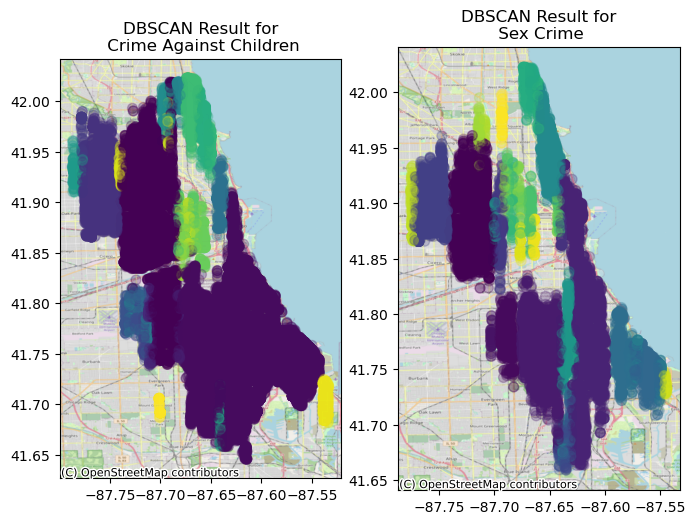

In [192]:
# For a clear layout, the noise points were excluded
dbscan_c_c=crime_children[crime_children.dbscan_labels_all>-1]
dbscan_c_s=crime_sexual[crime_sexual.dbscan_labels_all>-1]

# plot these points only 
fig,axs=plt.subplots(1,2,figsize=(8,8))
ax=axs[0]
children_scatter=ax.scatter(dbscan_c_c['Longitude'],dbscan_c_c['Latitude'],
                            c=dbscan_c_c.dbscan_labels_all,alpha=0.25, s=50)
contextily.add_basemap(
    ax,
    crs=crime_children.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)

ax=axs[1]
children_scatter=ax.scatter(dbscan_c_s['Longitude'],dbscan_c_s['Latitude'],
                            c=dbscan_c_s.dbscan_labels_all,alpha=0.25, s=50)
contextily.add_basemap(
    ax,
    crs=crime_sexual.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)

for i,ax in enumerate(axs):
    ax.set_title([
            'DBSCAN Result for\n Crime Against Children',
            'DBSCAN Result for\n Sex Crime'
        ][i],
        
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()
        

### Investigate if the clustering of crime has changed before and after Covid


In [61]:
# get data within 20 years
crime_children_pre = crime_children.loc[(crime_children.Date >= '2019-01-01 00:00:00') & (crime_children.Date <= '2019-12-31 23:59:00')]
crime_children_post = crime_children.loc[(crime_children.Date >= '2020-01-01 00:00:00') & (crime_children.Date <= '2021-01-01 00:00:00')]


In [60]:
crime_sex_pre = crime_sexual.loc[(crime_sexual.Date >= '2019-01-01 00:00:00') & (crime_sexual.Date <= '2019-12-31 23:59:00')]
crime_sex_post = crime_sexual.loc[(crime_sexual.Date >= '2020-01-01 00:00:00') & (crime_sexual.Date <= '2021-01-01 00:00:00')]

In [106]:
# since the input is location so there is no ground truth of labeling 
from sklearn.metrics import silhouette_score

def dbscan_model(df,input_1,input_2,radius,min_,status):
    # construct input array
    # parameter: input1, input2:target attributes that are used for clustering, in this case they are longitude and latitude
    
    input_arr=np.array(df[[input_1,input_2]],dtype='float64')
    ## note: the parameter status is used to specify the column name
    epsilon=radius/kms_per_radian # the range of cluster is innitisally set intuitively
    model=DBSCAN(eps=epsilon,min_samples=min_,algorithm='ball_tree',metric='haversine')
    dbscan=model.fit(np.radians(input_arr)) #the haversine metric requires radian
    labels=dbscan.labels_   #get label
    n_clusters=len(set(labels))
    n_noise=list(labels).count(-1)
    print(f'Estimatd Number of clusters  {status} Covid: {n_clusters}')
    print(f'Estimatd Number of noise points {status} Covid: {n_noise}')
    print(f"Silhouette Coefficient: {silhouette_score(np.radians(input_arr), labels,metric='haversine')}")
    # add label into the original dataframe
    df[f'dbscan_label_{status}']=labels
    df_noiseless=df[df[f'dbscan_label_{status}']!=-1]
    return df_noiseless
    #return the data set without noise to visualise


In [116]:
children_pre=dbscan_model(crime_children_pre,'Longitude','Latitude',0.1,10,'pre')
children_post=dbscan_model(crime_children_post,'Longitude','Latitude',0.1,10,'post')


Estimatd Number of clusters  pre Covid: 32
Estimatd Number of noise points pre Covid: 1863
Silhouette Coefficient: -0.5807024979509605
Estimatd Number of clusters  post Covid: 17
Estimatd Number of noise points post Covid: 1623


c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Silhouette Coefficient: -0.6643289542999352


c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


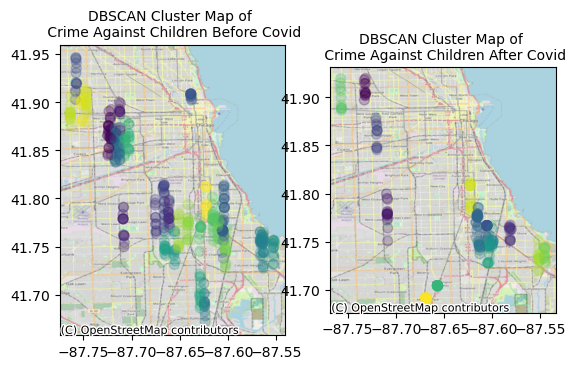

In [117]:
# visualise the cluster
fig,axs=plt.subplots(nrows=1, ncols=2)
axs[0].scatter(children_pre['Longitude'],children_pre['Latitude'],
                            c=children_pre.dbscan_label_pre,cmap='viridis',
                            alpha=0.25, s=50)
contextily.add_basemap(
    ax=axs[0],
    crs=children_pre.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
axs[1].scatter(children_post['Longitude'],children_post['Latitude'],
                            c=children_post.dbscan_label_post,cmap='viridis',
                            alpha=0.25, s=50)
contextily.add_basemap(
    ax=axs[1],
    crs=children_post.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
for i,ax in enumerate(axs):
    #ax.set_axis_off()
    ax.set_title(
        [
            "DBSCAN Cluster Map of \n Crime Against Children Before Covid",
            "DBSCAN Cluster Map of \n Crime Against Children After Covid",
        ][i],
        fontsize=10,
    )



    


In [183]:
sex_pre=dbscan_model(crime_sex_pre,'Longitude','Latitude',0.1,10,'pre')
sex_post=dbscan_model(crime_sex_post,'Longitude','Latitude',0.1,10,'post')


Estimatd Number of clusters  pre Covid: 12
Estimatd Number of noise points pre Covid: 1368
Silhouette Coefficient: -0.5894137037730375
Estimatd Number of clusters  post Covid: 5
Estimatd Number of noise points post Covid: 1066
Silhouette Coefficient: -0.4809047562574947


c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\skyla\miniconda3\envs\machinel\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


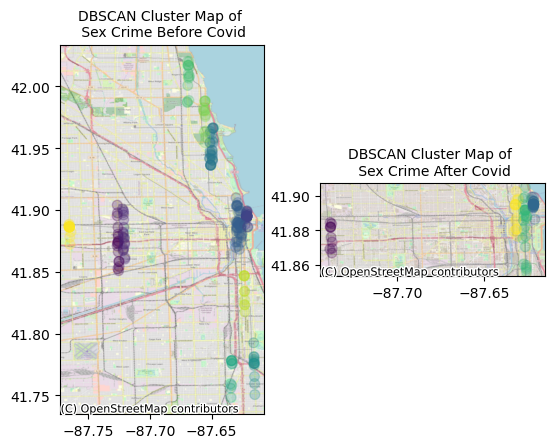

In [184]:
# visualise the cluster
fig,axs=plt.subplots(nrows=1, ncols=2)
axs[0].scatter(sex_pre['Longitude'],sex_pre['Latitude'],
                            c=sex_pre.dbscan_label_pre,cmap='viridis',
                            alpha=0.25, s=50)
contextily.add_basemap(
    ax=axs[0],
    crs=sex_pre.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
axs[1].scatter(sex_post['Longitude'],sex_post['Latitude'],
                            c=sex_post.dbscan_label_post,cmap='viridis',
                            alpha=0.25, s=50)
contextily.add_basemap(
    ax=axs[1],
    crs=sex_post.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
for i,ax in enumerate(axs):
        ax.set_title(
        [
            "DBSCAN Cluster Map of \n Sex Crime Before Covid",
            "DBSCAN Cluster Map of \n Sex Crime After Covid",
        ][i],
        fontsize=10,
    )


    


In [135]:
# check if there is any pattern within the clusters
cluters_s_pre=sex_pre.groupby('dbscan_label_pre')
cluters_s_post=sex_post.groupby('dbscan_label_post')

### HDBSCAN


In [132]:
def get_hdbscan_result(type,res):
    #res is the fitted clusterer
    #type is used to specify the type of crime in the printout 
    labels=res.labels_
    # number of clusters in labels
    n_clusters=len(set(labels))
    n_noise=list(labels).count(-1)
    print(f'Estimatd Number of clusters({type}) : {n_clusters}')
    print(f'Estimatd Number of noise points ({type}): {n_noise}')


* [Combine HDBSCAN with DBSCAN](:https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html)

In [212]:
import hdbscan
clusterer=hdbscan.HDBSCAN(metric='haversine',min_cluster_size=10,min_samples=50)
hdbscan_c=clusterer.fit_predict(np.radians(coords_c))
hdbscan_s=clusterer.fit_predict(np.radians(coords_s))


In [213]:
# store the labels in an additional column in the original dataframe
crime_children['hdbscan_labels_all']=hdbscan_c
crime_sexual['hdbscan_labels_all']=hdbscan_s


In [214]:
hdbscan_c_noiseless=crime_children[crime_children['hdbscan_labels_all']!=-1]
hdbscan_s_noiseless=crime_sexual[crime_sexual['hdbscan_labels_all']!=-1]


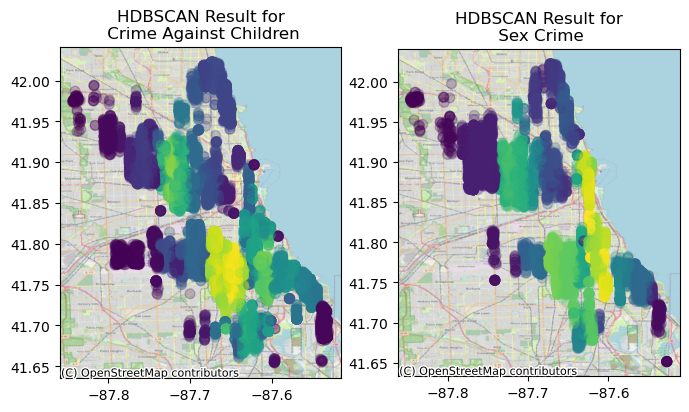

In [217]:
#crime_children.head(10)
#visualise
fig,ax=plt.subplots(1,2,figsize=(8,8))
ax[0].scatter(hdbscan_c_noiseless['Longitude'],hdbscan_c_noiseless['Latitude'],
                            c=hdbscan_c_noiseless.hdbscan_labels_all,cmap='viridis',
                            alpha=0.25, s=50)
contextily.add_basemap(
    ax=ax[0],
    crs=sex_pre.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
ax[1].scatter(hdbscan_s_noiseless['Longitude'],hdbscan_s_noiseless['Latitude'],
                            c=hdbscan_s_noiseless.hdbscan_labels_all,cmap='viridis',
                            alpha=0.25, s=50)
contextily.add_basemap(
    ax=ax[1],
    crs=sex_pre.crs,
    source=contextily.providers.OpenStreetMap.Mapnik
)
for i,ax in enumerate(ax):
    ax.set_title([
            'HDBSCAN Result for\n Crime Against Children',
            'HDBSCAN Result for\n Sex Crime'
        ][i],
        
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

## Compare performance of different clustering methods


In [206]:
#the following code is apdated from: https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html

## 
from sklearn import cluster
import time
plot_kwds={'alpha':0.2,'s':50,'linewidths':0}
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = seaborn.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)